# INFO-F-422 - Statistical Foundations of Machine Learning 

### Pascal Tribel - [pascal.tribel@ulb.be](mailto:pascal.tribel@ulb.be)
### Cédric Simar - [cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)
### Gian Marco Paldino - [gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)

## TP 6 - Classification

### Introduction
In classification the target is a category and its conditional distribution is 
$$P({\mathbf y}|x)$$
where:
- $\mathbf{y} \in \{ C_1,\dots, C_K\}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)

In classification, the goal of learning is to return an estimator 
$$h(x,\alpha)$$
of the conditional probabiity $P({\mathbf y}|x)$, where $\alpha$ denotes the set of parameters of the model $h$. 

The learning of the estimator is done  on the basis of an available input/output
training set $D_N$ made of $N$ observation pairs $(\mathbf{x}_i,y_i)$ where $x_i \in \mathbb{R}^n$. 

### Data generation
As seen in the theoretical course, there are multiple ways to generate datasets for binary classification problems.
#### Generative way:
First, generate the class $y_i \in \{0, 1\}$, using the _a priori_ probability, then generate the $x$ values, given the class conditional distribution $p(x | y=y_i)$.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

If we name the _a priori_ probability $p_1$, we can generate the $y$ dataset:

In [46]:
N = 500
n = 2
p1 = 0.4

Y = np.random.choice([0, 1], size=N, p=[1.0-p1,p1])

Then, we can generate the $x$ data, following two multivariate normal distribution (recall practical 1). We define two distributions, each for one of the two classes. Then, depending on the $y$ class of each item, we sample the corresponding multivariate normal distribution. 

In [47]:
A0 = np.random.rand(n, n)
cov0 = A0.T @ A0
mu0 = np.random.normal(loc=2, size=n)

A1 = np.random.rand(n, n)
cov1 = A1.T @ A1
mu1 = np.random.normal(size=n)

In [48]:
X = np.zeros((N, n))
for i in np.arange(N):
    if Y[i] == 1:
        X[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

Then, we plot the generated data. 

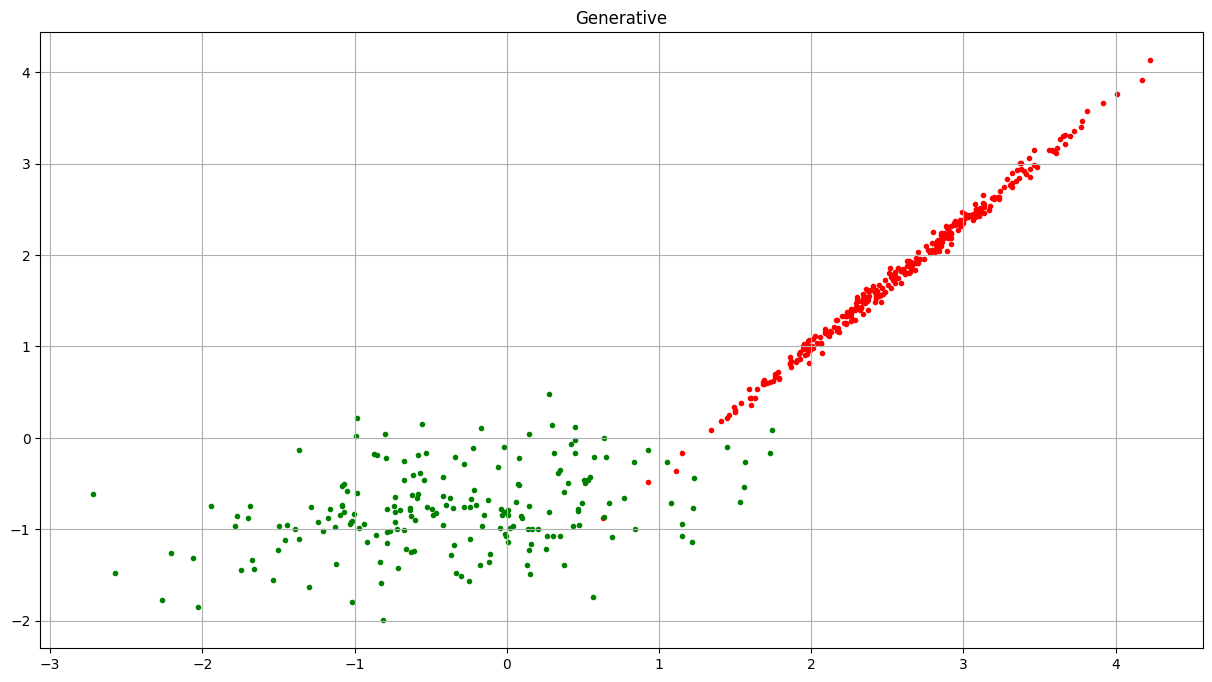

In [49]:
I0 = np.where(Y==0)
I1=np.where(Y==1)

plt.figure(figsize=(15, 8))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', color="red")
plt.scatter(X[I1, 0], X[I1, 1], marker='.', color="green")
plt.grid()
plt.title("Generative")
plt.show()

#### Discriminative way
Otherwise, if we have the conditional distributions $p(y|x)$, we can first sample $x$, then determine the class $y$.

In [50]:
from scipy.stats import multivariate_normal

In [51]:
def condprob(x,cov1,mu1,cov0,mu0,p1):
    return multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1/  \
        (multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1+    \
         multivariate_normal.pdf(x, mean=mu0, cov=cov0)*(1-p1))

First, we sample $x$ according to the probability density function:
$$p(x)= p_1*p(x|y=1) + (1-p_1)*p(x|y=0)$$

In [52]:
X = np.zeros((N,n))
for i in np.arange(N):
    if np.random.uniform()<p1:
        X[i,:] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
       X[i,:] = np.random.multivariate_normal(mu0, cov0, size=1)  

Then, using the Bayes theorem, we compute the $y$ classes.

In [53]:
Y = np.zeros((N,1))
for i in np.arange(N):
    p1i = condprob(X[i,:], cov1, mu1, cov0, mu0, p1)
    Y[i] = np.random.choice([0, 1], size=1, p=[1.0-p1i, p1i])

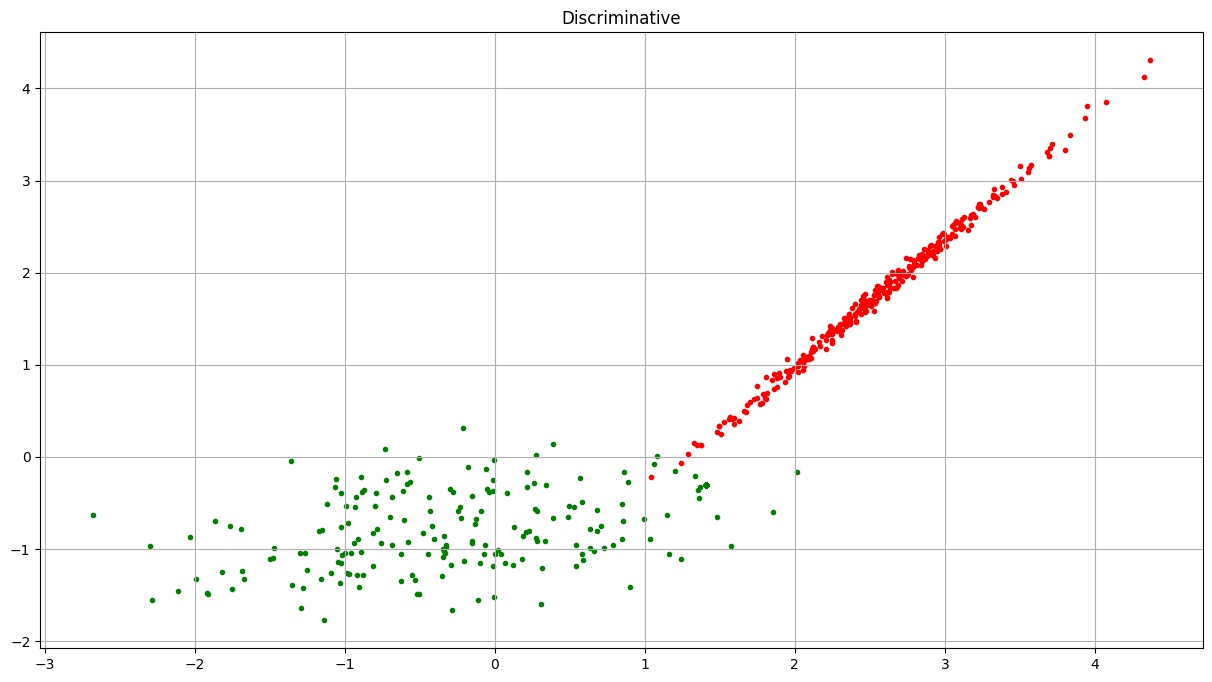

In [54]:
I0 = np.where(Y==0)
I1 = np.where(Y==1)

plt.figure(figsize=(15, 8))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', color="red")
plt.scatter(X[I1, 0], X[I1, 1],marker='.', color="green")
plt.grid()
plt.title("Discriminative")
plt.show()

Of course, the computed datasets are equivalent, no matter the method used.

### Exercise
* Can you adapt the two procedures to get more-dimensional data (i.e. $x$ is not in $\mathcal{R}^2$ but in $\mathcal{R}^n$) ?
* Can you adapt the two procedures to get more-classes data (i.e. $y$ is not in $\{0, 1\}$ but in $\{0,...,n\}$) ?

### Metrics and model evaluations methods
In the previous practicals, when we were dealing with regression tasks, we defined different metrics for evaluating the quality of some model's predictions. Remind: we defined the Mean Squared Error, then, we normalized it to define the Normalized Mean Squared Error. We spoke about other metrics, such as the MAE. All those quantities, while highly informative when applied to continuous quantities, are not as useful when dealing with classes.

Let us consider a practical example. You are assigned the task to determine if some rocket components are working (1) or not (0). In this task, it seems clear that the fact of assigning _working_ to a _non-working_ piece is worse than assigning _non-working_ to a _working_ piece (you could lose astronauts). However, this is not reflected by the MSE: in both cases, assigning the wrong label would lead to an error of $1$. 

In binary classification, however, we can determine entirely the cases possible after prediction:
* Expected: 0, Predicted: 0 -> True Negative (TN)
* Expected: 1, Predicted: 1 -> True Positive (TP)
* Expected: 0, Predicted: 1 -> False Positive (FP)
* Expected: 1, Predicted: 0 -> False Negative (FN)

In this terminology, it is clear that the previous example suffers more from the False Positives than the False Negatives.

We can present those quantities in a matrix, called the *confusion matrix*:

| |Negative|Positive|
|-|-|-|
|True|TN|TP|
|False|FN|FP|

In `sklearn`, the function `confusion_matrix` builds it from the set of expected and predicted labels. This, however, is not so-to-say a scoring method. There are different values, derived from the confusion matrix quantities, that allows to score a given prediction set:
* The **precision**: $\frac{\text{TP}}{2\text{TP}+\text{FP}}$
* The **recall**: $\frac{\text{TP}}{2\text{TP}+\text{FN}}$
* The **F1 score**: $\frac{2\text{TP}}{2\text{TP}+\text{FP}+\text{FN}}$ which is the harmonic mean between the precision and the recall scores
* More generally, the **F Beta score**:  $\frac{(1+\beta^2)\text{TP}}{(1+\beta^2)\text{TP}+\text{FP}+\beta^2\text{FN}}$

However, those quantities often do not take into account the number of True Negatives. Nonetheless, the labels can arbitrarily be inverted in order to use the same function (in which cases would this be helpful?). Note: most of those scoring methods are implemented in `sklearn`.

### Linear model for classification
As it has been done for the regression tasks, we can use a linear model for classifying the previously generated points. As an example, in `sklearn`, we can use the `LogisticRegression` class:

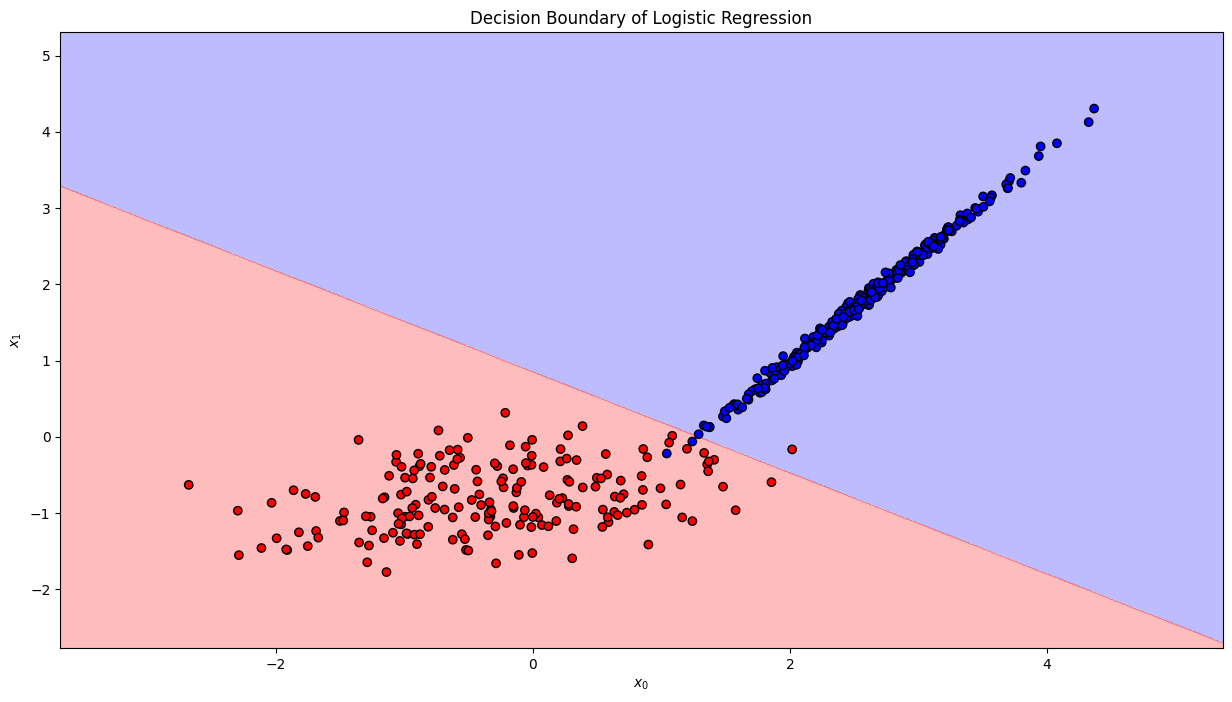

In [83]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X, Y.ravel())

def plot_field(X, Y, model, name=""):
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 1000),
                           np.linspace(x1_min, x1_max, 1000))
    
    Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()]).reshape(xx0.shape)
    
    plt.figure(figsize=(15, 8))
    plt.contourf(xx0, xx1, Z, alpha=0.3, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.bwr)
    
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.title(f"Decision Boundary of {name}")
    plt.show()

plot_field(X, Y, model, "Logistic Regression")

Now, for fun, we can train another model to see how the space is then divided: 

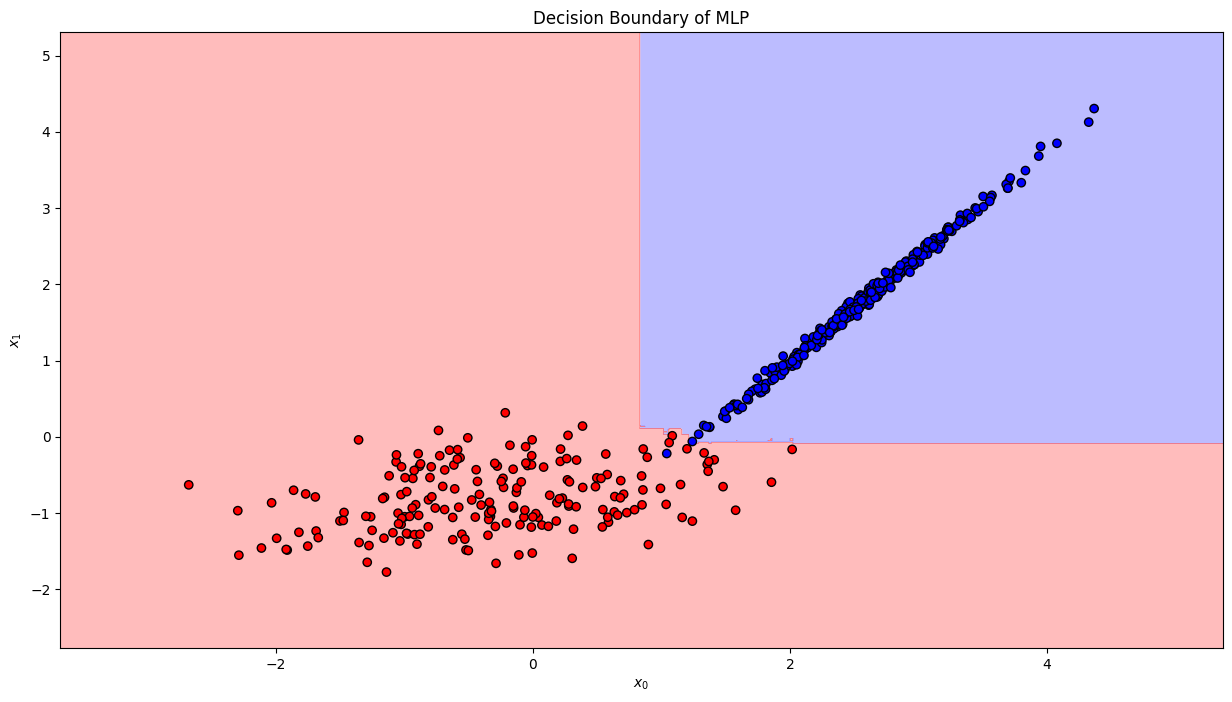

In [86]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X, Y.ravel())

plot_field(X, Y, model, "MLP")

#### Exercise: polynomial features
* Extend the dataset by adding polynomial features (e.g., degree 2)
* Train a logistic regression model on both the original and extended datasets.
* Compare decision boundaries and discuss the effect of feature engineering (note: see previous practicals for hint).

#### Exercise: KNN
* Implement a KNN classifier (`sklearn.neighbors.KNeighborsClassifier`).
* Vary $k$ (e.g., 1, 5, 20) and visualize decision boundaries.
* Discuss underfitting/overfitting trade-offs.

#### Exercise: Bayes
* Compute the true Bayes decision boundary using the known distributions $p(x|y)$.
* Compare it to the decision boundaries of logistic regression and KNN.
* Discuss the optimality of Bayes classification.

#### Exercise: Other models
* Use other models to classify $X$ and $Y$ and show their decision boundaries.
* Compare their performances using the different metrics.

#### Exercise: Active learning

* Train a logistic regression classifier on only 20% of the dataset.
* Select new points to label based on model uncertainty (e.g., samples near decision boundary).
* Retrain and measure accuracy gain.
* Discuss the benefits of active learning in data labeling.

### ROC curve
Let us define two important notions:
* The **sensibility**: $\frac{\text{TP}}{\text{TP}+\text{FN}}$. On all the indeed positive cases, what is the portion of correctly assigned positive?
* The **specificity**: $\frac{\text{TN}}{\text{TN}+\text{FP}}$. On all the indeed negative cases, what is the portion of correctly assigned negative?

The _anti-_ versions of both are given by $1 - x$ for each. Now, let us use a simple threshold model. That is, for a given threshold, if the sample is below, classify it as 0, otherwise classify it as 1. For multiple values of this threshold, the **ROC** curve (for _receiver operating characteristic_) is a plot in which the antispecificity is put in absisse, and the sensibility in ordinate. The **precision/recall** plot displays the precision vs. the recall. Finally, the **lift** curve shows the proportion of _assigned positives_ among all the points (the _alert_ level).

/var/folders/g7/l9_hhr256md6lt7yldvmnjjw0000gn/T/ipykernel_29821/3996528818.py:25: RuntimeWarning: invalid value encountered in scalar divide
  PR[tt] = TP / (TP + FP)


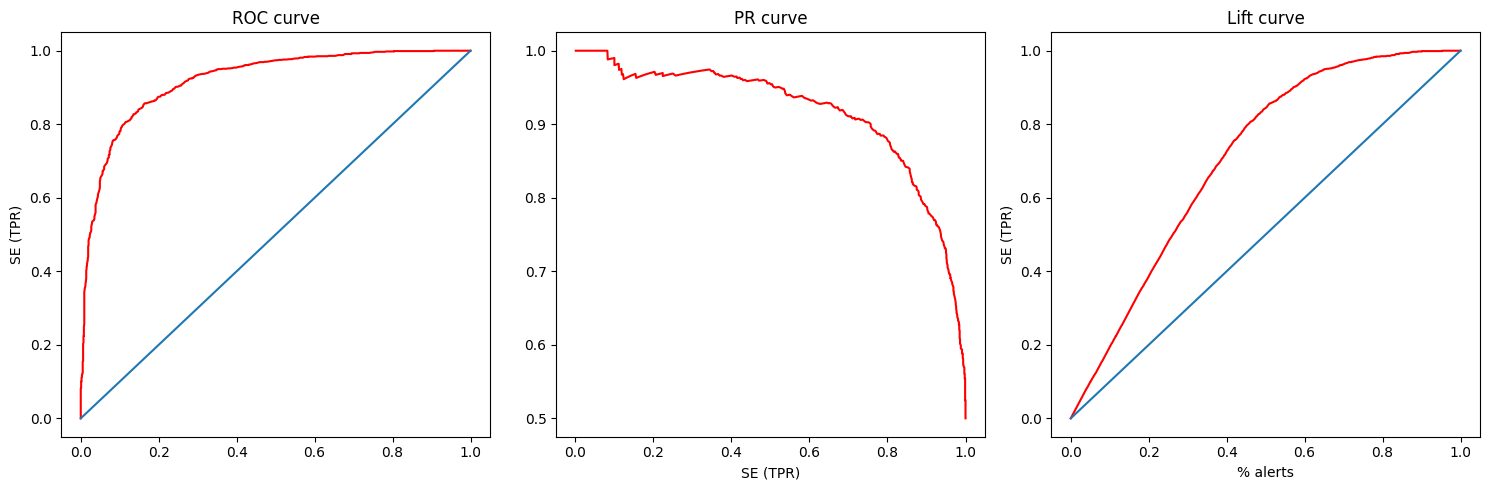

In [88]:
mu_p = 1
sd_p = 1

mu_n = -1
sd_n = 1

TT = np.arange(-10, 10.01, 0.01)
FPR = np.zeros(len(TT))
SE = np.zeros(len(TT))
PR = np.zeros(len(TT))
AL = np.zeros(len(TT))
N = 2000
DNp = np.random.normal(mu_p, sd_p, N//2)
DNn = np.random.normal(mu_n, sd_n, N//2)

for tt in range(len(TT)):
    thr = TT[tt]
    
    FN = np.sum(DNp < thr)
    FP = np.sum(DNn > thr)
    TN = np.sum(DNn < thr)
    TP = np.sum(DNp > thr)
    FPR[tt] = FP / (FP + TN)
    SE[tt] = TP / (TP + FN)
    PR[tt] = TP / (TP + FP)
    AL[tt] = (TP + FP) / (N)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(FPR, SE, color="red", linestyle="-")
plt.plot(FPR, FPR)
plt.title("ROC curve")
plt.ylabel("SE (TPR)")

plt.subplot(1, 3, 2)
plt.plot(SE, PR, color="red", linestyle="-")
plt.title("PR curve")
plt.xlabel("SE (TPR)")

plt.subplot(1, 3, 3)
plt.plot(AL, SE, color="red", linestyle="-")
plt.plot(AL, AL)
plt.title("Lift curve")
plt.ylabel("SE (TPR)")
plt.xlabel("% alerts")

plt.tight_layout()
plt.show()

### Summary of the Machine Learning pipeline